## Load Data

In [22]:
import pandas as pd
df = pd.read_csv('../Project/covid-selected/train.csv',index_col ='Country_Region')
df.head()

,Id,Province_State,Date,ConfirmedCases,Fatalities
Country_Region,,,,,
Afghanistan,1,NaN,2020-01-22,0.0,0.0
Afghanistan,2,NaN,2020-01-23,0.0,0.0
Afghanistan,3,NaN,2020-01-24,0.0,0.0
Afghanistan,4,NaN,2020-01-25,0.0,0.0
Afghanistan,5,NaN,2020-01-26,0.0,0.0


In [23]:
# convert date into datetime
df['Date'] = pd.to_datetime(df['Date'])

## Case Study: China

In [24]:
sub_df = df.loc['China',:]
sub_df.head()

,Id,Province_State,Date,ConfirmedCases,Fatalities
Country_Region,,,,,
China,6157,Anhui,2020-01-22,1.0,0.0
China,6158,Anhui,2020-01-23,9.0,0.0
China,6159,Anhui,2020-01-24,15.0,0.0
China,6160,Anhui,2020-01-25,39.0,0.0
China,6161,Anhui,2020-01-26,60.0,0.0


In [25]:
#Confirmed Cases Sum for Every Date
sub_df_summed = sub_df['ConfirmedCases'].groupby(sub_df['Date']).sum()
sub_df_summed2=sub_df_summed.reset_index()

In [26]:
# Fatalities Sum for Every Date
sub_df_dead_summed = sub_df['Fatalities'].groupby(sub_df['Date']).sum()
sub_df_dead_summed2=sub_df_dead_summed.reset_index()

In [76]:
def process_data(df, country):
    # Initialize new df for specified country
    country_df = pd.DataFrame()
    # Sum cases and fatalities by date
    country_df['ConfirmedCases'] = df.loc[country,'ConfirmedCases'].groupby(df.loc[country,'Date']).sum()
    country_df['Fatalities'] = df.loc[country,'Fatalities'].groupby(df.loc[country,'Date']).sum()
    # Only keep days since first case
    country_df = country_df.loc[country_df['ConfirmedCases'] > 0,:]
    # Reset index to use date as a column
    country_df = country_df.reset_index()
    # Set days as an integer since the first case
    country_df['days'] = country_df['Date'] - country_df.loc[0,'Date']
    country_df['days'] = country_df['days'].dt.days
    return country_df
    
    

In [50]:
process_data(df,'China')

,Date,ConfirmedCases,Fatalities,days
0,2020-01-22,548.0,17.0,0
1,2020-01-23,643.0,18.0,1
2,2020-01-24,920.0,26.0,2
3,2020-01-25,1406.0,42.0,3
4,2020-01-26,2075.0,56.0,4
...,...,...,...,...
74,2020-04-05,82602.0,3333.0,74
75,2020-04-06,82665.0,3335.0,75
76,2020-04-07,82718.0,3335.0,76
77,2020-04-08,82809.0,3337.0,77


In [90]:
def split_data(country_df, test_size=0.8):
    split_index = round(len(country_df.index)*test_size)
    train = country_df.loc[country_df.index < split_index, :]
    test = country_df.loc[country_df.index >= split_index, :]
    x_train = train['days']
    x_test = test['days']
    y_train = train['ConfirmedCases']
    y_test = test['ConfirmedCases']
    return x_train, x_test, y_train, y_test

In [61]:
split_data(process_data(df,'China'))

C:\Users\044yo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


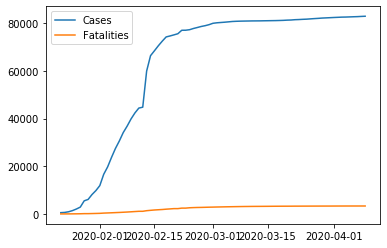

In [16]:
#Plotting Chinese Confirmed Cases Data
import seaborn as sns
sns.lineplot(data=sub_df_summed, label='Cases')
sns.lineplot(data=sub_df_dead_summed, hue='r', label='Fatalities')

## Modeling: Logistic Growth (Peaking Included)

In [60]:
#Defining Logistic Growth Function
def logisticf(t,a,b,c):
    logistic_growth=c/(1+a*np.exp(-b*t))
    return logistic_growth

In [64]:
p0=np.random.exponential(size=3)
#Convert the dates to days since the first listed day
dates=sub_df_summed2.iloc[:,0]-sub_df_summed2.iloc[0,0]
#sub_df_summed2['days']=dt.days
sub_df_summed2['days']=dates.dt.days
sub_df_summed2.head()

,Date,ConfirmedCases,days
0,2020-01-22,548.0,0
1,2020-01-23,643.0,1
2,2020-01-24,920.0,2
3,2020-01-25,1406.0,3
4,2020-01-26,2075.0,4


In [68]:
import scipy.optimize as optim
import numpy as np
#fit to a logistic function 
x = np.array(sub_df_summed2['days'])
y=np.array(sub_df_summed2['ConfirmedCases'])
bounds =(0,[100000., 3., 1000000.])
(a,b,c), cov = optim.curve_fit(logisticf, x_train,y_train, bounds=bounds,p0=p0)
print(a,b,c)

51.271168248984125 0.221523589852277 81021.46997050659


In [69]:
#Function with the fitted parameters from optimize
def logigrowth(t):
    return  c/(1+a*np.exp(-b*t))
logigrowth(5)

4516.959442438933

Text(0, 0.5, 'Confirmed Cases')

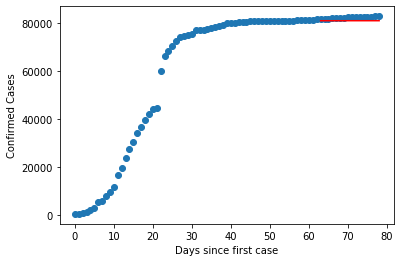

In [71]:
import matplotlib.pyplot as plt
#Scatter plot the data and show the fitted line of logistic function 
plt.scatter(x,y)
plt.plot(x_test, logigrowth(x_test), 'r')
plt.xlabel('Days since first case')
plt.ylabel('Confirmed Cases')

## Future plans for the team assignment
0. Shift the dates to start from the first case
1. Import HDI data from Global Data Lab and countries' urbanization levels/regions from the World Bank
2. Explore predicting logistic function parameter values from the imported variable values
3. Scale to population
Motivation: Better prediction for countries with less developed healthcare systems 

In [137]:
from sklearn.metrics import mean_absolute_error
results = dict()
# Get list of countries that have had at least 1000 cases
country_list = df.loc[df['ConfirmedCases'] > 1000,:].index.unique()
# Loop over countries...
for country in country_list:
    try:
        x_train, x_test, y_train, y_test = split_data(process_data(df,country))
        p0=np.random.exponential(size=3)
        bounds =(0,[100000., 3., 1000000.])
        (a,b,c), cov = optim.curve_fit(logisticf, x_train,y_train, bounds=bounds,p0=p0)
        def logigrowth(t):
            return  c/(1+a*np.exp(-b*t))
        mae = mean_absolute_error(y_test, logigrowth(x_test))
        print(country, 'mae:',round(mae), 'total cases:', y_test.iloc[-1], round(mae/y_test.iloc[-1]*100),'%')
        plot_stuff = (x_train,y_train,x_test,y_test,x_test,logigrowth(x_test))
        results[country] = (mae, y_test.iloc[-1], (plot_stuff))
    except:
        print(f"Error with {country}")
    

Algeria mae: 255.0 total cases: 1666.0 15.0 %
Argentina mae: 136.0 total cases: 1795.0 8.0 %
Australia mae: 696.0 total cases: 6108.0 11.0 %
Austria mae: 426.0 total cases: 13244.0 3.0 %
Belarus mae: 526.0 total cases: 1486.0 35.0 %
Belgium mae: 1065.0 total cases: 24983.0 4.0 %
Brazil mae: 5212.0 total cases: 18092.0 29.0 %
Canada mae: 4891.0 total cases: 20641.0 24.0 %
Chile mae: 782.0 total cases: 5972.0 13.0 %
China mae: 1321.0 total cases: 82883.0 2.0 %
Colombia mae: 222.0 total cases: 2223.0 10.0 %
Croatia mae: 170.0 total cases: 1407.0 12.0 %
Czechia mae: 545.0 total cases: 5569.0 10.0 %
Denmark mae: 1298.0 total cases: 5830.0 22.0 %
Dominican Republic mae: 201.0 total cases: 2349.0 9.0 %
Ecuador mae: 1074.0 total cases: 4965.0 22.0 %
Egypt mae: 388.0 total cases: 1699.0 23.0 %
Estonia mae: 143.0 total cases: 1207.0 12.0 %
Finland mae: 349.0 total cases: 2605.0 13.0 %
Error with France
Germany mae: 4574.0 total cases: 118181.0 4.0 %
Greece mae: 182.0 total cases: 1955.0 9.0 %
Ic

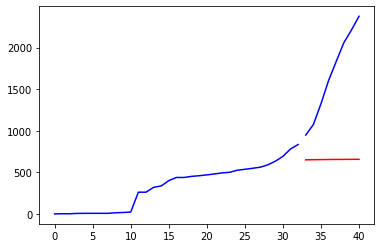

In [141]:
mae, cases, plot_stuff = results['Qatar']
x_train, y_train, x_test, y_test, x_test, y_test_pred = plot_stuff
plt.plot(x_train,y_train, 'b', x_test,y_test, 'b', x_test, y_test_pred, 'r')